In [1]:
import cv2
import torch
from torch import nn
from d2l import torch as d2l
from torch.utils.data import DataLoader
import os

## Data Loading

In [2]:
path = "../Data/images_original/metal/metal00000.png"
obs = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
obs = obs[35:-36:, 54:-43]
obs = torch.from_numpy(obs)
obs = torch.reshape(obs, (1,1,217,335))
obs = obs.to(dtype = torch.float32)

In [3]:
class_dict = {'blues' : 0,
              'classical': 1,
              'country': 2,
              'disco' : 3,
              'hiphop' : 4,
              'jazz' : 5,
              'metal' : 6,
              'pop' : 7,
              'reggae': 8,
              'rock' : 9    
}

In [4]:
def collect_data():
    data = []
    # Collect all images from the 10 genres
    for genre in os.listdir("../Data/images_original"):
        for image in os.listdir("../Data/images_original/" + genre):
            image_path = "../Data/images_original/" + genre + "/" + image
            grayscale_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            grayscale_img = grayscale_img[35:-36:, 54:-43]
            grayscale_img = torch.tensor(grayscale_img).to(dtype = torch.float32).clone().detach().requires_grad_(True)  #.requires_grad(True)
            #grayscale_img = torch.tensor(grayscale_img, requires_grad=True)
            # Splitting each image vertically into 5 different parts
            for i in range(5):
                # The data loader adds a dimension so I've removed a dimension from the image and class
                data.append((grayscale_img[ : ,  (67*i):67*(i+1)].reshape(1,217,67), torch.tensor(class_dict.get(genre)))) #.reshape(1)))
            
    return data         


In [5]:
data = collect_data()

In [6]:
len(data)

4995

In [7]:
data[500]   #[0].shape

(tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [16., 74., 66.,  ..., 32., 44., 25.],
          [16., 74., 66.,  ..., 32., 44., 25.],
          [ 6., 26., 20.,  ...,  3.,  0.,  0.]]],
        grad_fn=<ReshapeAliasBackward0>),
 tensor(1))

In [8]:
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

train_dataset[2]

(tensor([[[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          ...,
          [107., 105., 205.,  ..., 165., 153., 141.],
          [107., 105., 205.,  ..., 165., 153., 141.],
          [103., 102., 109.,  ...,  96.,  96.,  95.]]],
        grad_fn=<ReshapeAliasBackward0>),
 tensor(4))

In [9]:
# Get data in dataloader format
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

## First CNN

In [ ]:
'''
Parameters
'''

epochs = 50
lr = 0.1
batch_size = 10

'''
Net

'''

net = nn.Sequential(

    nn.Conv2d(1, 32, kernel_size=3, padding = "same"), nn.Sigmoid(),
 
    nn.AvgPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(32, 64, kernel_size=3, padding = "same"), nn.ReLU(),
 
    nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, padding = "same"), nn.Dropout(0.1), nn.Sigmoid(),

    nn.AvgPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(128, 256, kernel_size = 2, padding = "same"), nn.ReLU(),
    
    nn.AvgPool2d(kernel_size=2, stride = 2),
    
    nn.Conv2d(256, 512, kernel_size = 2, padding = "same"), nn.Sigmoid(),
    
    nn.AvgPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(512, 1024, kernel_size = 3, padding = "same"), nn.ReLU(),
    
    nn.AvgPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(1024, 2048, kernel_size = 3, padding = "same"), nn.Sigmoid(),
    
    nn.Flatten(),
    
    nn.Linear(30720, 5000), nn.Dropout(0.2), nn.ReLU(),
    
    nn.Linear(5000, 4096), nn.Sigmoid(),
    
    nn.Linear(4096, 512), nn.Sigmoid(),
    
    nn.Linear(512, 64), nn.ReLU(),
    
    nn.Linear(64, 10), nn.Sigmoid(),
      
)


'''
Loss
'''

loss = nn.CrossEntropyLoss(reduction='none')

'''
Trainer
'''

trainer = torch.optim.Adam(net.parameters(), lr=lr)



# Sandbox net 
## Do whatever you want with this

In [ ]:
'''
Parameters
'''

epochs = 50
lr = 0.1
batch_size = 10

'''
Net

'''

net1 = nn.Sequential(

    nn.Conv2d(1, 16, kernel_size=2, padding = "same"), nn.Sigmoid(),
 
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(16, 32, kernel_size=2, padding = "same"), nn.Dropout(0.1), nn.Sigmoid(),

    nn.AvgPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(32, 128, kernel_size = 2, padding = "same"), nn.Dropout(0.1), nn.ReLU(),
    
    nn.MaxPool2d(kernel_size=2, stride = 2),
    
    nn.Conv2d(128, 256, kernel_size = 2, padding = "same"), nn.ReLU(),
    
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(256, 1024, kernel_size = 2, padding = "same"), nn.Dropout(0.2), nn.ReLU(),
    
    nn.AvgPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(1024, 2048, kernel_size = 2, padding = "same"), nn.ReLU(),
    
    nn.Flatten(),
    
    nn.Linear(122880, 20000), nn.Dropout(0.2), nn.ReLU(),
    
    nn.Linear(512, 128), nn.ReLU(),
    
    nn.Linear(128, 10), nn.ReLU()
      
)


'''
Loss
'''

loss = nn.CrossEntropyLoss(reduction='none')

#loss = nn.KLDivLoss(reduction='none')


'''
Trainer
'''

trainer = torch.optim.Adam(net1.parameters(), lr=lr)



In [74]:
'''
Parameters
'''

epochs = 50
lr = 0.1
batch_size = 10

'''
Net

'''

net2 = nn.Sequential(

    nn.Conv2d(1, 16, kernel_size=4, padding = "same"), nn.Sigmoid(),
 
    nn.MaxPool2d(kernel_size=4, stride=4),

    nn.Conv2d(16, 32, kernel_size=4, padding = "same"), nn.Dropout(0.2), nn.Sigmoid(),

    nn.AvgPool2d(kernel_size=4, stride=4),
    
    nn.Conv2d(32, 64, kernel_size =4, padding = "same"), nn.Dropout(0.2), nn.ReLU(),
    
    nn.MaxPool2d(kernel_size=4, stride = 4),
    
    #nn.Conv2d(128, 256, kernel_size = 2, padding = "same"), nn.ReLU(),
    
    #nn.MaxPool2d(kernel_size =2, stride = 2),
    
    #nn.Conv2d(256, 512, kernel_size = 3, padding = "same"), nn.Dropout(0.2), nn.ReLU(),
    
    #nn.AvgPool2d(kernel_size = 2, stride = 3),
    
    #nn.Conv2d(1024, 2048, kernel_size = 2, padding = "same"), nn.ReLU(),
    
    nn.Flatten(),
    
    #nn.Linear(9216, 4096), nn.Dropout(0.2), nn.ReLU(),
    
    #nn.Linear(4096, 1024), nn.Dropout(0.2), nn.ReLU(),
    
    #nn.Linear(1024, 512), nn.Dropout(0.2), nn.Sigmoid(),
    
    nn.Linear(192, 128), nn.Dropout(0.2), nn.ReLU(), 
    
    nn.Linear(128, 32), nn.Sigmoid(),
    
    nn.Linear(32, 10), nn.Sigmoid()
      
)


'''
Loss
'''

loss = nn.CrossEntropyLoss(reduction='none')

#loss = nn.KLDivLoss(reduction='none')


'''
Trainer
'''

trainer = torch.optim.Adam(net2.parameters(), lr=lr)



In [39]:
path = "../Data/images_original/metal/metal00000.png"
obs = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
obs = obs[35:-36:, 54:-43]
obs = torch.from_numpy(obs)
obs = torch.reshape(obs, (1,1,217,335))
obs = obs.to(dtype = torch.float32)

### One Observation

# This doesn't work for `net1` but it still manages to train idk

In [40]:
'''
One observation
'''

for layer in net2:
    obs = layer(obs)
    print(layer.__class__.__name__,'output shape: \t',obs.shape)

Conv2d output shape: 	 torch.Size([1, 16, 217, 335])
Sigmoid output shape: 	 torch.Size([1, 16, 217, 335])
MaxPool2d output shape: 	 torch.Size([1, 16, 72, 111])
Conv2d output shape: 	 torch.Size([1, 32, 72, 111])
Dropout output shape: 	 torch.Size([1, 32, 72, 111])
Sigmoid output shape: 	 torch.Size([1, 32, 72, 111])
AvgPool2d output shape: 	 torch.Size([1, 32, 24, 37])
Conv2d output shape: 	 torch.Size([1, 128, 24, 37])
Dropout output shape: 	 torch.Size([1, 128, 24, 37])
ReLU output shape: 	 torch.Size([1, 128, 24, 37])
MaxPool2d output shape: 	 torch.Size([1, 128, 7, 11])
Flatten output shape: 	 torch.Size([1, 9856])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x9856 and 768x512)

### Loop

loss 1.860, train acc 0.434, test acc 0.429
100.1 examples/sec on cpu


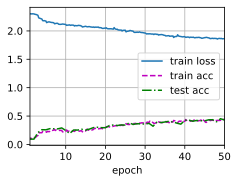

In [75]:
d2l.train_ch6(net2, train_loader, test_loader, epochs, lr, d2l.try_gpu())

In [ ]:
net1.eval()

In [52]:
test_dataset[0]

(tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [19., 90., 86.,  ..., 96., 95., 96.],
          [19., 90., 86.,  ..., 96., 95., 96.],
          [ 0.,  0.,  0.,  ...,  9., 16.,  8.]]],
        grad_fn=<ReshapeAliasBackward0>),
 tensor(5))

In [76]:
test_batch = next(iter(test_loader))

In [77]:
input_data = test_batch[0]

In [78]:
net2.eval()
with torch.no_grad():
    output = net2(input_data)

In [79]:
import numpy as np

In [80]:
output_np = output.numpy()
predicted_label = np.argmax(output_np, axis=1)

In [81]:
true_label = test_batch[1].numpy()
print("True label:      ", true_label)
print("Predicted label: ", predicted_label)

True label:       [5 3 9 4 9 0 2 5 8 0]
Predicted label:  [5 7 0 4 9 5 2 5 6 5]
